In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulation.ThreeCoilSimulation import WoundCoil, ThreeCoilSystem
from simulation.utils import wire_gauge_to_metric
from simulation.FEMPipeSim import FEMPipe, PipeSimulation

In [2]:
# Define coil parameters
tx_coil = WoundCoil(
    orientation='z',
    position=(0, 0, 0),
    radius=0.125,      # 12.5 cm radius
    turns=40,
    wire_diameter=wire_gauge_to_metric(22), # 20 AWG wire
    resistivity=1.68e-8, # Copper resistivity in ohm-m
    capacitance=1e-14
)

rx_coil = WoundCoil(
    orientation='z',
    position=(1.0, 0, 0),  # 30 cm separation
    radius=0.05,           # 5 cm radius
    turns=50,
    wire_diameter=wire_gauge_to_metric(26), 
    resistivity=1.68e-8,
    capacitance=1e-12
)

bucking_coil = WoundCoil(
    orientation='z',
    position=(0.5, 0, 0),  # Initial guess for optimal position
    radius=0.05,            # 5 cm radius
    turns=5,
    wire_diameter=wire_gauge_to_metric(26),
    resistivity=1.68e-8,
    capacitance=1e-18
)

system = ThreeCoilSystem(tx_coil, rx_coil, bucking_coil, spacing=0.005)

In [3]:
# ## Find optimal bucking coil position
# system.find_bucking_distance(axis='x', bracket=[0.2, 0.9])
# print(f"Optimal bucking coil position: {system.bucking_coil.position}")
# print(f"Resulting mutual inductance: {system.M_total*1e6:.3f} µH")


In [4]:
print("TX-coil resistance: {:.4f} Ω".format(tx_coil.resistance))
print("RX-coil resistance: {:.4f} Ω".format(rx_coil.resistance))
print("Bucking-coil resistance: {:.4f} Ω".format(bucking_coil.resistance))

TX-coil resistance: 1.6213 Ω
RX-coil resistance: 2.0496 Ω
Bucking-coil resistance: 0.2050 Ω


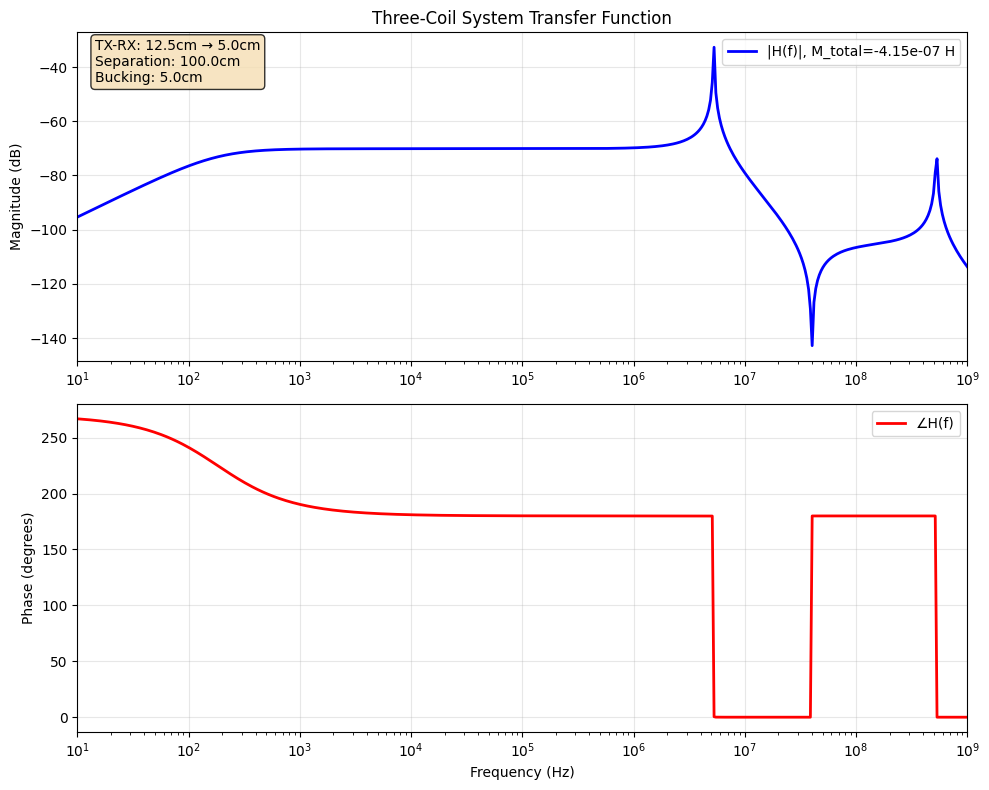

In [5]:
fig = system.plot_transfer_function(frequencies=np.logspace(1, 9, 500), R_load=1e9)

In [14]:
# Define pipe parameters
pipe = FEMPipe(
    length=0.5,          # 1 meter long pipe
    sigma=5.8e7,        # Conductivity of copper in S/m
    mu_r=1.0,           # Relative permeability
    radius=0.2,          # 10 cm radius
    orientation=np.array([1.0, 0.0, 0.0]), # Aligned along x-axis
    position=(2.0, 0, -0.5), # a bit below the coil system
    n_rings=10
)

# Create simulation
pipe_sim = PipeSimulation(three_coil=system, fem_pipes=pipe)
response = pipe_sim.transfer_function(freqs=np.logspace(-1, 7, 500))

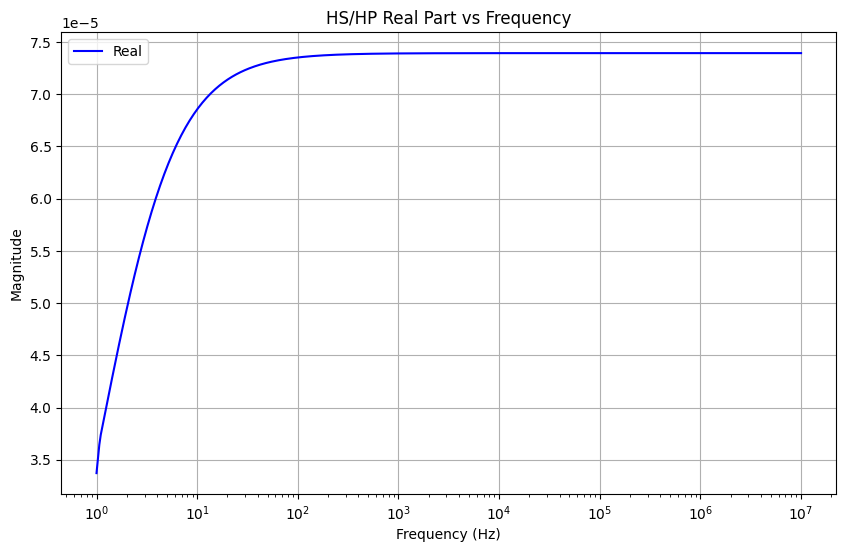

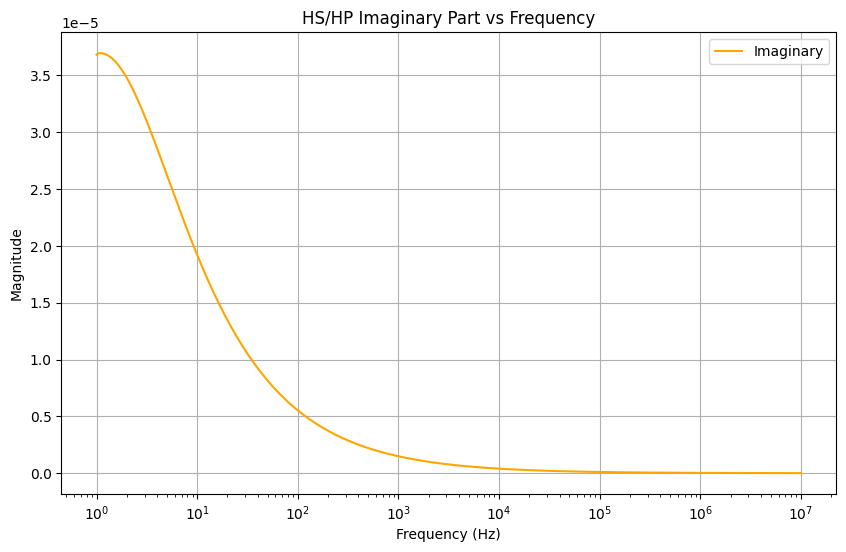

In [15]:
# Plot real part
plt.figure(figsize=(10, 6))
plt.plot(np.logspace(0, 7, 500), np.real(response), label='Real', color='blue')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('HS/HP Real Part vs Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Plot imaginary part
plt.figure(figsize=(10, 6))
plt.plot(np.logspace(0, 7, 500), np.imag(response), label='Imaginary', color='orange')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('HS/HP Imaginary Part vs Frequency')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# Grid search simulation over pipe-like object
def grid_search_simulation(scanner, pipe, x_range, y_range, z_height, frequencies, R_load=1e6):
    """
    Perform a grid search simulation over a pipe-like object.
    
    Args:
        scanner: ThreeCoilSystem object
        pipe: FEMPipe object representing the target
        x_range: tuple (x_min, x_max, num_points) for x-axis grid
        y_range: tuple (y_min, y_max, num_points) for y-axis grid  
        z_height: height above the pipe to perform the survey
        frequencies: array of frequencies to simulate
        R_load: load resistance
    
    Returns:
        tuple: (x_grid, y_grid, real_response, imag_response)
    """
    x_min, x_max, nx = x_range
    y_min, y_max, ny = y_range
    
    x_positions = np.linspace(x_min, x_max, nx)
    y_positions = np.linspace(y_min, y_max, ny)
    
    x_grid, y_grid = np.meshgrid(x_positions, y_positions)
    
    real_response = np.zeros((ny, nx))
    imag_response = np.zeros((ny, nx))
    
    pipe_sim = PipeSimulation(scanner=scanner, pipes=[pipe])
    
    print(f"Running grid search over {nx}x{ny} = {nx*ny} points...")
    
    for i, y in enumerate(y_positions):
        for j, x in enumerate(x_positions):
            position = np.array([x, y, z_height])
            response = pipe_sim.simulate(position, frequencies, R_load, hs_hp=True)
            
            # Take response at middle frequency for visualization
            mid_freq_idx = len(frequencies) // 2
            complex_resp = response[mid_freq_idx]
            
            real_response[i, j] = np.real(complex_resp)
            imag_response[i, j] = np.imag(complex_resp)
            
        if (i + 1) % 5 == 0:
            print(f"Completed {i+1}/{ny} rows")
    
    return x_grid, y_grid, real_response, imag_response

def plot_survey_heatmaps(x_grid, y_grid, real_response, imag_response, pipe_position, figsize=(15, 6)):
    """
    Plot real and imaginary response as heat maps.
    
    Args:
        x_grid, y_grid: coordinate grids
        real_response, imag_response: response matrices
        pipe_position: position of the pipe for reference
        figsize: figure size
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Real part heat map
    im1 = ax1.contourf(x_grid, y_grid, real_response, levels=20, cmap='RdBu_r')
    ax1.set_xlabel('X Position (m)')
    ax1.set_ylabel('Y Position (m)')
    ax1.set_title('Real Part Response')
    ax1.set_aspect('equal')
    
    # Mark pipe position
    ax1.plot(pipe_position[0], pipe_position[1], 'ko', markersize=10, markerfacecolor='yellow', 
             markeredgecolor='black', markeredgewidth=2, label='Pipe Center')
    ax1.legend()
    
    plt.colorbar(im1, ax=ax1, label='Real Response')
    
    # Imaginary part heat map
    im2 = ax2.contourf(x_grid, y_grid, imag_response, levels=20, cmap='RdBu_r')
    ax2.set_xlabel('X Position (m)')
    ax2.set_ylabel('Y Position (m)')
    ax2.set_title('Imaginary Part Response')
    ax2.set_aspect('equal')
    
    # Mark pipe position
    ax2.plot(pipe_position[0], pipe_position[1], 'ko', markersize=10, markerfacecolor='yellow',
             markeredgecolor='black', markeredgewidth=2, label='Pipe Center')
    ax2.legend()
    
    plt.colorbar(im2, ax=ax2, label='Imaginary Response')
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

In [9]:
# Run grid search simulation
# Define survey grid parameters
x_range = (-2.0, 2.0, 50)  # 20 points from -0.5m to 1.5m
y_range = (-2.0, 2.0, 50)  # 20 points from -0.5m to 0.5m  
z_height = 0.5  # Survey height 5cm above the pipe

# Use a subset of frequencies for faster computation
survey_frequencies = np.logspace(2, 5, 100)  # 100 frequencies from 100Hz to 1MHz

# Perform grid search
x_grid, y_grid, real_resp, imag_resp = grid_search_simulation(
    scanner=system, 
    pipe=pipe, 
    x_range=x_range, 
    y_range=y_range, 
    z_height=z_height,
    frequencies=survey_frequencies,
    R_load=1e6
)

TypeError: PipeSimulation.__init__() got an unexpected keyword argument 'scanner'

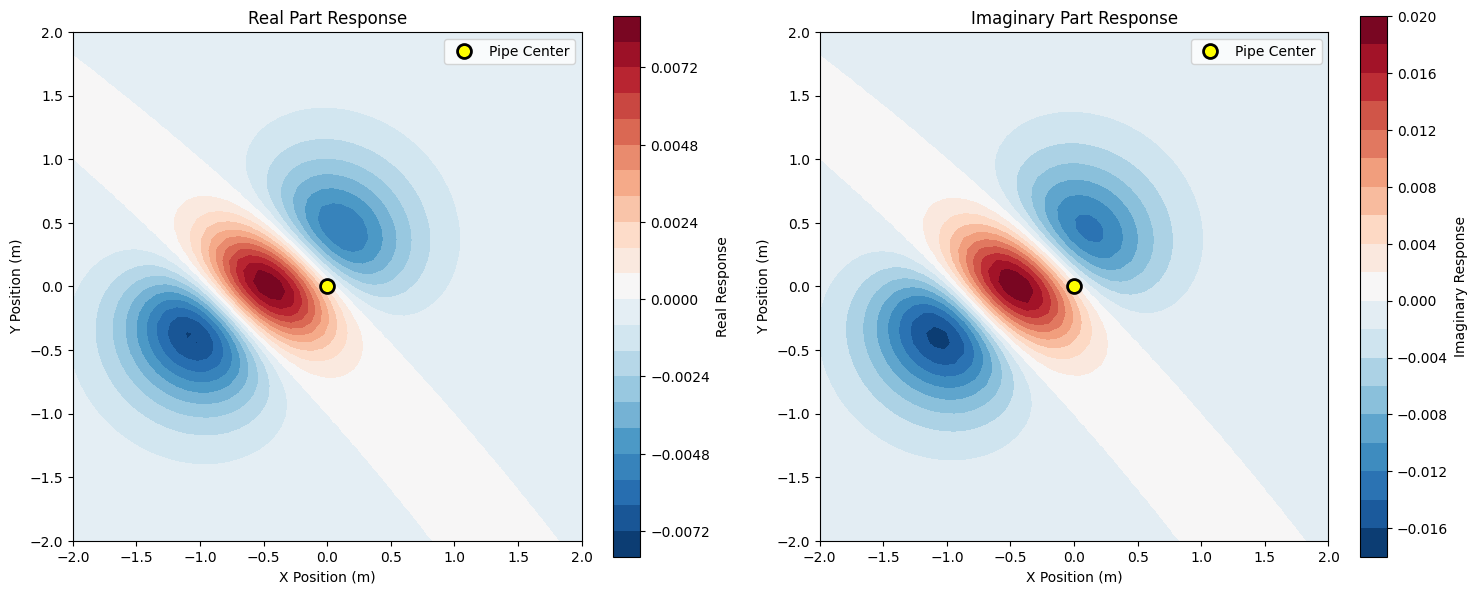

Survey completed over 50x50 grid
Real response range: -7.25e-03 to 8.55e-03
Imaginary response range: -1.66e-02 to 1.95e-02
Pipe position: (0.00, 0.00, -0.50) m
Survey height: 0.50 m above pipe


In [10]:
# Plot the survey results as heat maps
fig, axes = plot_survey_heatmaps(
    x_grid, y_grid, real_resp, imag_resp, 
    pipe_position=pipe.position[:2],  # Only x,y coordinates for 2D plot
    figsize=(15, 6)
)

# Print some statistics about the survey
print(f"Survey completed over {x_grid.shape[1]}x{x_grid.shape[0]} grid")
print(f"Real response range: {np.min(real_resp):.2e} to {np.max(real_resp):.2e}")
print(f"Imaginary response range: {np.min(imag_resp):.2e} to {np.max(imag_resp):.2e}")
print(f"Pipe position: ({pipe.position[0]:.2f}, {pipe.position[1]:.2f}, {pipe.position[2]:.2f}) m")
print(f"Survey height: {z_height:.2f} m above pipe")

In [11]:
def plot_survey_transect(scanner, pipe, start_point, end_point, num_points, z_height, frequencies, R_load=1e6, figsize=(12, 8)):
    """
    Plot the electromagnetic response along a straight line transect over the target.
    
    Args:
        scanner: ThreeCoilSystem object
        pipe: FEMPipe object representing the target
        start_point: (x, y) coordinates of transect start
        end_point: (x, y) coordinates of transect end
        num_points: number of measurement points along the transect
        z_height: height above the pipe to perform the survey
        frequencies: array of frequencies to simulate
        R_load: load resistance
        figsize: figure size
    
    Returns:
        tuple: (distances, real_response, imag_response, fig, axes)
    """
    # Create points along the transect
    x_points = np.linspace(start_point[0], end_point[0], num_points)
    y_points = np.linspace(start_point[1], end_point[1], num_points)
    
    # Calculate distances from start point for x-axis
    distances = np.sqrt((x_points - start_point[0])**2 + (y_points - start_point[1])**2)
    
    real_response = np.zeros(num_points)
    imag_response = np.zeros(num_points)
    
    pipe_sim = PipeSimulation(scanner=scanner, pipes=[pipe])
    
    print(f"Running transect simulation over {num_points} points...")
    
    for i in range(num_points):
        position = np.array([x_points[i], y_points[i], z_height])
        response = pipe_sim.simulate(position, frequencies, R_load, hs_hp=True)
        
        # Take response at middle frequency for visualization
        mid_freq_idx = len(frequencies) // 2
        complex_resp = response[mid_freq_idx]
        
        real_response[i] = np.real(complex_resp)
        imag_response[i] = np.imag(complex_resp)
        
        if (i + 1) % 10 == 0:
            print(f"Completed {i+1}/{num_points} points")
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Real part transect
    ax1.plot(distances, real_response, 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_ylabel('Real Response')
    ax1.set_title(f'Survey Transect: ({start_point[0]:.1f},{start_point[1]:.1f}) to ({end_point[0]:.1f},{end_point[1]:.1f})')
    ax1.grid(True, alpha=0.3)
    
    # Mark pipe center projection onto transect
    pipe_center = pipe.position[:2]
    # Find closest point on transect to pipe center
    transect_vec = np.array(end_point) - np.array(start_point)
    if np.linalg.norm(transect_vec) > 0:
        t = np.dot(pipe_center - np.array(start_point), transect_vec) / np.dot(transect_vec, transect_vec)
        t = np.clip(t, 0, 1)  # Clamp to transect bounds
        closest_distance = t * np.linalg.norm(transect_vec)
        ax1.axvline(x=closest_distance, color='red', linestyle='--', alpha=0.7, label='Pipe Center Projection')
        ax1.legend()
    
    # Imaginary part transect  
    ax2.plot(distances, imag_response, 'r-', linewidth=2, marker='o', markersize=4)
    ax2.set_xlabel('Distance along transect (m)')
    ax2.set_ylabel('Imaginary Response')
    ax2.grid(True, alpha=0.3)
    
    if np.linalg.norm(transect_vec) > 0:
        ax2.axvline(x=closest_distance, color='red', linestyle='--', alpha=0.7, label='Pipe Center Projection')
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return distances, real_response, imag_response, fig, (ax1, ax2)

Running transect simulation over 50 points...
Completed 10/50 points
Completed 20/50 points
Completed 30/50 points
Completed 40/50 points
Completed 50/50 points


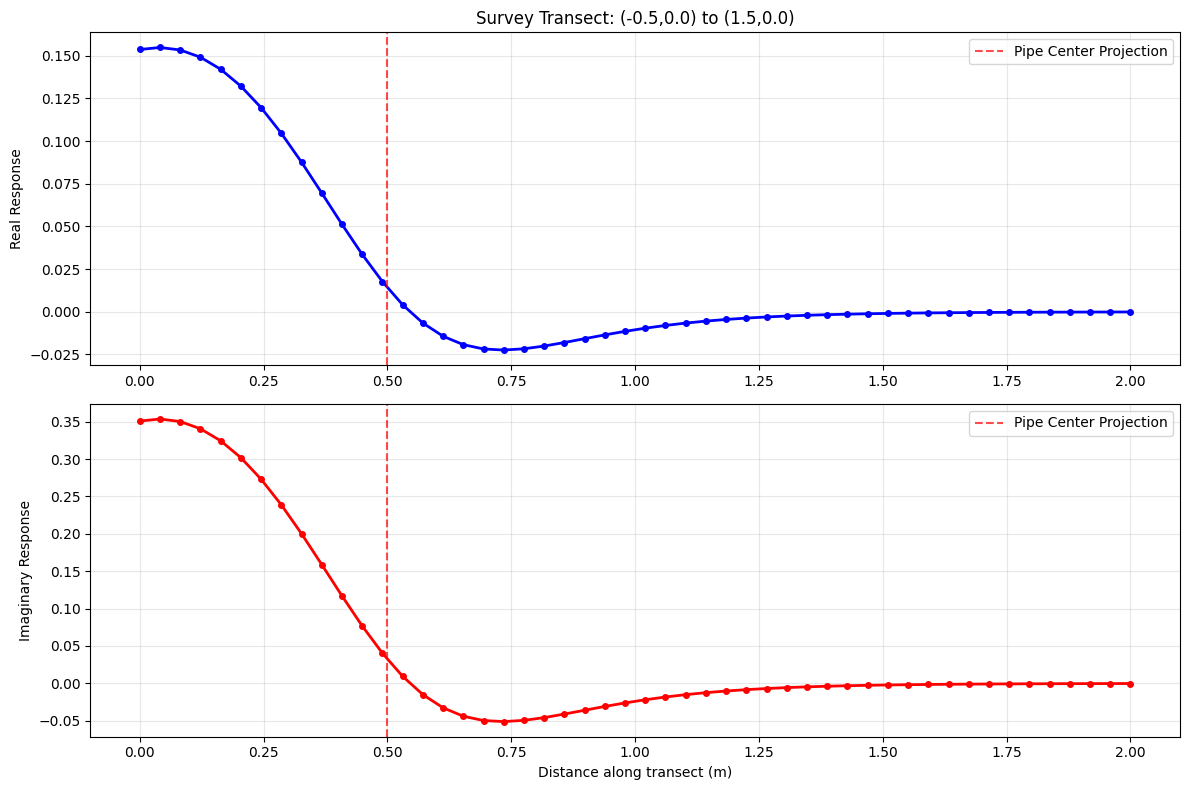

In [12]:
# Example transect: walk across the pipe from left to right
distances, real_resp_transect, imag_resp_transect, fig_transect, axes_transect = plot_survey_transect(
    scanner=system,
    pipe=pipe,
    start_point=(-0.5, 0.0),  # Start at x=-0.5m, y=0m
    end_point=(1.5, 0.0),     # End at x=1.5m, y=0m  
    num_points=50,
    z_height=0.05,
    frequencies=survey_frequencies,
    R_load=1e6
)